In [1]:
!pip install ddsketch cvxpy

In [2]:
import json
from collections import defaultdict
from operator import itemgetter
from pathlib import Path
import ddsketch
import medmnist
import pandas as pd
import torch
import numpy as np
from ddsketch import DDSketch

%matplotlib inline
import matplotlib.pyplot as plt; plt.style.use('bmh')
import matplotlib as mpl

In [3]:
path_to_experiments = Path('../new_experiments/')

In [4]:
# dataset = 'mnist'
# dataset = 'fashion'
dataset = 'cifar10'
# dataset = 'cifar100'
# dataset = 'bloodmnist'
# dataset = 'pathmnist'
# dataset = 'tissuemnist'
# dataset = 'fitzpatrick'
# model = 'cnn'
model = 'small_resnet14'

def load_scores(experiment: Path = None) -> dict:
    try:
        print(experiment)
        load = lambda p: torch.load(p, map_location=torch.device('cpu'))
        stage = 'stage2' if 'tct' in experiment.name else 'stage1'
        val_scores = load(*(experiment / 'scores').glob(f'*_{stage}_val_scores.pth'))
        val_targets = load(*(experiment / 'scores').glob(f'*_{stage}_val_targets.pth'))
        test_scores = load(*(experiment / 'scores').glob(f'*_{stage}_test_scores.pth'))
        test_targets = load(*(experiment / 'scores').glob(f'*_{stage}_test_targets.pth'))
        return dict(val_scores=val_scores, val_targets=val_targets, test_scores=test_scores, test_targets=test_targets)
    except Exception as e:
        print(e)
        return None

experiments = {
    'central': load_scores(*path_to_experiments.glob(f'{dataset}_central_{model}')),
    'tct': load_scores(*path_to_experiments.glob(f'{dataset}_tct_{model}')),
    'fedavg': load_scores(*path_to_experiments.glob(f'{dataset}_fedavg_{model}')),
    'tct_iid': load_scores(*path_to_experiments.glob(f'{dataset}_tct_{model}*iid_partition')),
    'fedavg_iid': load_scores(*path_to_experiments.glob(f'{dataset}_fedavg_{model}*iid_partition')),
}
experiments = {k: v for k, v in experiments.items() if v is not None}

if dataset in ('cifar10', 'fashion'):
    clients_class_map = {
        'client_1': [0, 1],
        'client_2': [2, 3],
        'client_3': [4, 5],
        'client_4': [6, 7],
        'client_5': [8, 9],
    }
    num_classes = 10
elif dataset == 'cifar100':
    num_classes = 100
    clients_class_map = {
        "client_1": [0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
        "client_2": [10, 11, 12, 13, 14, 15, 16, 17, 18, 19],
        "client_3": [20, 21, 22, 23, 24, 25, 26, 27, 28, 29],
        "client_4": [30, 31, 32, 33, 34, 35, 36, 37, 38, 39],
        "client_5": [40, 41, 42, 43, 44, 45, 46, 47, 48, 49],
        "client_6": [50, 51, 52, 53, 54, 55, 56, 57, 58, 59],
        "client_7": [60, 61, 62, 63, 64, 65, 66, 67, 68, 69],
        "client_8": [70, 71, 72, 73, 74, 75, 76, 77, 78, 79],
        "client_9": [80, 81, 82, 83, 84, 85, 86, 87, 88, 89],
        "client_10": [90, 91, 92, 93, 94, 95, 96, 97, 98, 99],
    }
    
elif dataset in ('bloodmnist', 'tissuemnist'):
    clients_class_map = {
        'client_1': [0, 1],
        'client_2': [2, 3],
        'client_3': [4, 5],
        'client_4': [6, 7],
    }
    num_classes = 8
elif dataset == 'pathmnist':
    clients_class_map = {
        'client_1': [0, 1],
        'client_2': [2, 3],
        'client_3': [4, 5],
        'client_4': [6, 7, 8],
    }
    num_classes = 9
    

../new_experiments/cifar10_central_small_resnet14
../new_experiments/cifar10_tct_small_resnet14
../new_experiments/cifar10_fedavg_small_resnet14
../new_experiments/cifar10_tct_small_resnet14_iid_partition
../new_experiments/cifar10_fedavg_small_resnet14_iid_partition


In [5]:
def accuracy(scores, targets):
    correct = scores.argmax(1) == targets
    total = targets.size(0)
    return (correct.sum() / total).item()

In [6]:
for k, v in experiments.items():
    print(f"\n{k.upper().center(40, '=')}")
    print(f"{accuracy(v['val_scores'], v['val_targets']) = :.0%}")
    print(f"{accuracy(v['test_scores'], v['test_targets']) = :.0%}")



================CENTRAL=================
accuracy(v['val_scores'], v['val_targets']) = 89%
accuracy(v['test_scores'], v['test_targets']) = 88%

==================TCT===================
accuracy(v['val_scores'], v['val_targets']) = 83%
accuracy(v['test_scores'], v['test_targets']) = 83%

=================FEDAVG=================
accuracy(v['val_scores'], v['val_targets']) = 49%
accuracy(v['test_scores'], v['test_targets']) = 52%

================TCT_IID=================
accuracy(v['val_scores'], v['val_targets']) = 91%
accuracy(v['test_scores'], v['test_targets']) = 89%

===============FEDAVG_IID===============
accuracy(v['val_scores'], v['val_targets']) = 91%
accuracy(v['test_scores'], v['test_targets']) = 89%


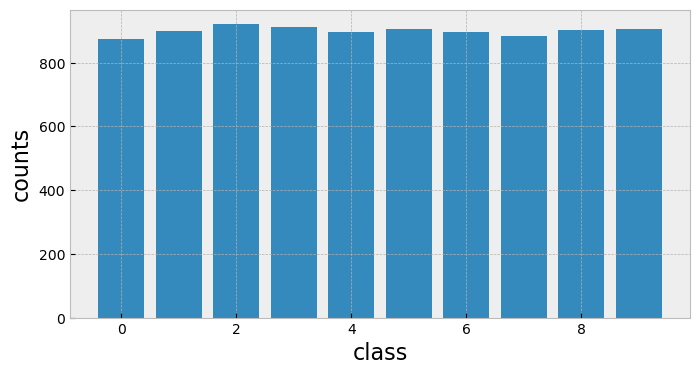

In [7]:
def plot_label_dist(labels, fontsize=16):
    counts = np.bincount(labels)
    plt.figure(figsize=(8, 4))
    plt.bar(range(len(counts)), counts)
    plt.xlabel('class', fontsize=fontsize)
    plt.ylabel('counts', fontsize=fontsize)
    plt.show()

plot_label_dist(experiments['central']['test_targets'])

## Calibration

In [8]:
def calc_bins(scores, targets):
    # Assign each prediction to a bin
    num_bins = 10
    bins = np.linspace(0.1, 1, num_bins)
    binned = np.digitize(scores, bins)

    # Save the accuracy, confidence and size of each bin
    bin_accs = np.zeros(num_bins)
    bin_confs = np.zeros(num_bins)
    bin_sizes = np.zeros(num_bins)

    for bin in range(num_bins):
        bin_sizes[bin] = len(scores[binned == bin])
        if bin_sizes[bin] > 0:
            bin_accs[bin] = (targets[binned==bin]).sum() / bin_sizes[bin]
            bin_confs[bin] = (scores[binned==bin]).sum() / bin_sizes[bin]

    return bins, binned, bin_accs, bin_confs, bin_sizes

In [9]:
def get_calibration_metrics(scores, targets):
    ECE = 0
    MCE = 0
    bins, _, bin_accs, bin_confs, bin_sizes = calc_bins(scores, targets)

    for i in range(len(bins)):
        abs_conf_dif = abs(bin_accs[i] - bin_confs[i])
        ECE += (bin_sizes[i] / sum(bin_sizes)) * abs_conf_dif
        MCE = max(MCE, abs_conf_dif)

    return ECE, MCE

In [10]:
def temp_scale(logits, labels, plot=True):
    temperature = torch.nn.Parameter(torch.ones(1))#.to('cuda' if torch.cuda.is_available() else 'cpu')
    # print(temperature.is_leaf)
    criterion = torch.nn.CrossEntropyLoss()

    # Removing strong_wolfe line search results in jump after 50 epochs
    optimizer = torch.optim.LBFGS([temperature], lr=0.001, max_iter=10000, line_search_fn='strong_wolfe')

    temps = []
    losses = []

    def _eval():
        loss = criterion(torch.div(logits, temperature), labels)
        loss.backward()
        temps.append(temperature.item())
        losses.append(loss.item())
        return loss

    optimizer.step(_eval)

    if plot: print('Final T_scaling factor: {:.2f}'.format(temperature.item()))

    if plot:
        plt.figure(figsize=(9, 2))
        plt.subplot(121)
        plt.plot(list(range(len(temps))), temps)

        plt.subplot(122)
        plt.plot(list(range(len(losses))), losses)
        plt.show()
    return temperature.detach()


In [11]:
import matplotlib.patches as mpatches

def draw_reliability_graph(logits, targets, use_temp_scale=True, title=None):
    
    if use_temp_scale:
        T = temp_scale(logits, targets)
        temp_scores = torch.softmax(logits / T, 1)
        
    scores = torch.softmax(logits, 1)
    targets = torch.nn.functional.one_hot(targets)
        
    ECE, MCE = get_calibration_metrics(scores, targets)
    bins, _, bin_accs, _, _ = calc_bins(scores, targets)
    if use_temp_scale:
        temp_ECE, temp_MCE = get_calibration_metrics(temp_scores, targets)
        temp_bins, _, temp_bin_accs, _, _ = calc_bins(temp_scores, targets)

    fig, ax = plt.subplots(ncols=2 , figsize=(5*(2 if use_temp_scale else 1), 5))
    if title is not None:
        fig.suptitle(title, fontsize=24)

    # x/y limits
    ax[0].set_xlim(0, 1.05)
    ax[0].set_ylim(0, 1)
    if use_temp_scale:
        ax[1].set_xlim(0, 1.05)
        ax[1].set_ylim(0, 1)

    # x/y labels
    ax[0].set_xlabel('Confidence')
    ax[0].set_ylabel('Accuracy')
    if use_temp_scale:
        ax[1].set_xlabel('Confidence')
        ax[1].set_ylabel('Accuracy')

    # Create grid
    # ax.set_axisbelow(True) 
    # ax.grid(color='gray', linestyle='dashed')

    # Error bars
    ax[0].bar(bins, bins,  width=0.1, alpha=0.3, edgecolor='black', color='r', hatch='\\')
    if use_temp_scale:
        ax[1].bar(temp_bins, temp_bins,  width=0.1, alpha=0.3, edgecolor='black', color='r', hatch='\\')

    # Draw bars and identity line
    ax[0].bar(bins, bin_accs, width=0.1, alpha=1, edgecolor='black', color='b')
    ax[0].plot([0,1],[0,1], '--', color='gray', linewidth=2)
    if use_temp_scale:
        ax[1].bar(temp_bins, temp_bin_accs, width=0.1, alpha=1, edgecolor='black', color='b')
        ax[1].plot([0,1],[0,1], '--', color='gray', linewidth=2)

    # Equally spaced axes
    ax[0].set_aspect('equal', adjustable='box')
    if use_temp_scale:
        ax[1].set_aspect('equal', adjustable='box')

    # ECE and MCE legend
    ECE_patch = mpatches.Patch(color='green', label='ECE = {:.2f}%'.format(ECE*100))
    MCE_patch = mpatches.Patch(color='red', label='MCE = {:.2f}%'.format(MCE*100))
    ax[0].legend(handles=[ECE_patch, MCE_patch])
    if use_temp_scale:
        temp_ECE_patch = mpatches.Patch(color='green', label='ECE = {:.2f}%'.format(temp_ECE*100))
        temp_MCE_patch = mpatches.Patch(color='red', label='MCE = {:.2f}%'.format(temp_MCE*100))
        ax[1].legend(handles=[temp_ECE_patch, temp_MCE_patch])
        
    ax[0].set_title('no temperature', fontsize=16)
    if use_temp_scale:
        ax[1].set_title('temperature', fontsize=16)

    fig.tight_layout()
    plt.show()

    # plt.savefig('calibrated_network.png', bbox_inches='tight')

Final T_scaling factor: 0.11


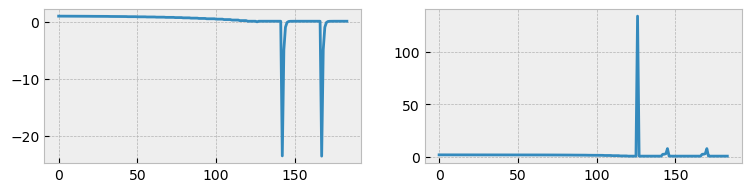

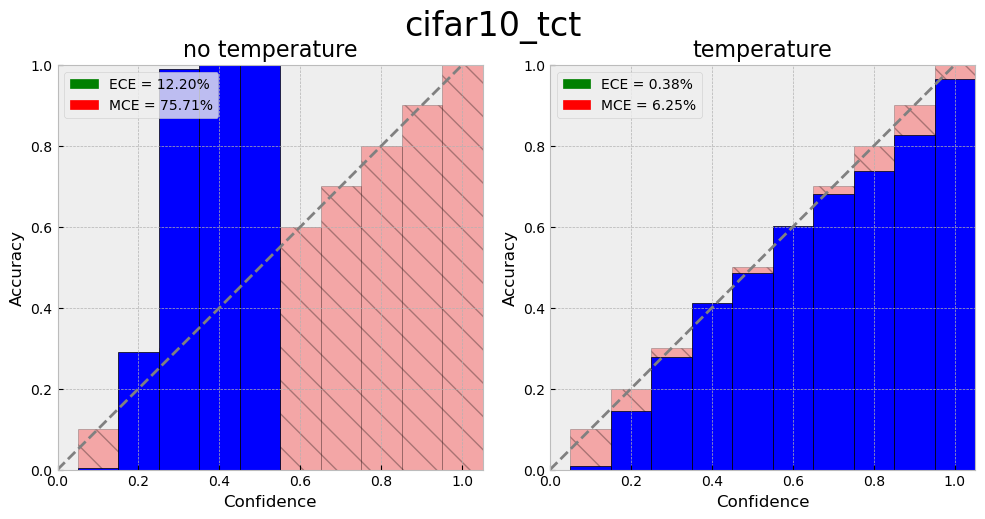

In [12]:
exp = 'tct'
preds = experiments[exp]

scores  = preds['test_scores']
targets = preds['test_targets']
draw_reliability_graph(scores, targets, True, title=f'{dataset}_{exp}')

In [13]:
def get_temp_scale_cal_metrics(logits, targets):
    T = temp_scale(logits, targets, plot=False)
    scores = torch.softmax(logits, 1)
    temp_scores = torch.softmax(logits / T, 1)
    one_hot_targets = torch.nn.functional.one_hot(targets)
    ece, mce = get_calibration_metrics(scores, one_hot_targets)
    temp_ece, temp_mce = get_calibration_metrics(temp_scores, one_hot_targets)
    return dict(ece=ece, mce=mce, temp_ece=temp_ece, temp_mce=temp_mce)

for k, v in experiments.items():
    print(k.upper().ljust(10, '='), "ECE", f"{get_temp_scale_cal_metrics(v['test_scores'], v['test_targets'])['ece']:.2%}", end='\t')
    print('ECE with temperature scaling', f"{get_temp_scale_cal_metrics(v['test_scores'], v['test_targets'])['temp_ece']:.2%}")

CENTRAL=== ECE 1.46%	ECE with temperature scaling 0.10%
TCT======= ECE 12.20%	ECE with temperature scaling 0.38%
FEDAVG==== ECE 1.73%	ECE with temperature scaling 0.42%
TCT_IID=== ECE 13.20%	ECE with temperature scaling 0.30%
FEDAVG_IID ECE 1.58%	ECE with temperature scaling 0.12%


## conformal prediction

In [37]:
def calibrate_lac(scores, targets, alpha=0.1, return_dist=False):
    assert scores.size(0) == targets.size(0)
    n = torch.tensor(targets.size(0))
    assert n
    
    score_dist = torch.take_along_dim(1 - scores, targets.unsqueeze(1), 1).flatten()
    qhat = 1 - torch.quantile(score_dist, torch.ceil((n+1)*(1-alpha))/n, interpolation='higher')
    return (qhat, score_dist) if return_dist else qhat

def inference_lac(scores, qhat, allow_empty_sets=False):
    n = scores.size(0)
    
    elements_mask = scores >= qhat
    
    if not allow_empty_sets:
        elements_mask[torch.arange(n), scores.argmax(1)] = True

    return elements_mask

def calibrate_aps(scores, targets, alpha=0.1, return_dist=False):
    assert scores.size(0) == targets.size(0)
    n = torch.tensor(targets.size(0))
    assert n
    
    sorted_index = torch.argsort(scores, descending=True)
    sorted_scores_cumsum = torch.take_along_dim(scores, sorted_index, dim=1).cumsum(dim=1)
    score_dist = torch.take_along_dim(sorted_scores_cumsum, sorted_index.argsort(1), 1)[torch.arange(n), targets]
    assert 0 <= ((n+1)*(1-alpha))/n <=1, f'{alpha=} {n=} {((n+1)*(1-alpha))/n=}'
    qhat = torch.quantile(score_dist, torch.ceil((n+1)*(1-alpha))/n, interpolation='higher')
    return (qhat, score_dist) if return_dist else qhat

def inference_aps(scores, qhat, allow_empty_sets=False):
    sorted_index = scores.argsort(1, descending=True)
    sorted_scores_cumsum = torch.take_along_dim(scores, sorted_index, dim=1).cumsum(1)
    elements_mask = sorted_scores_cumsum <= qhat
    
    if not allow_empty_sets:
        elements_mask[:, 0] = True
        
    prediction_sets = torch.take_along_dim(elements_mask, sorted_index.argsort(1), 1)
    return prediction_sets

def calibrate_raps(scores, targets, alpha=0.1, k_reg=1, lam_reg=0.03):
    # RAPS regularization parameters (larger lam_reg and smaller k_reg leads to smaller sets)
    assert scores.size(0) == targets.size(0)
    n = torch.tensor(targets.size(0))
    num_classes = scores.shape[1]
    reg = torch.cat([torch.zeros(k_reg), torch.tensor([lam_reg]).repeat(num_classes - k_reg)]).unsqueeze(0)
    
    sorted_index = torch.argsort(scores, descending=True)
    reg_sorted_scores = reg + torch.take_along_dim(scores, sorted_index, 1)
    score_dist = torch.take_along_dim(reg_sorted_scores.cumsum(1), sorted_index.argsort(1), 1)[torch.arange(n), targets]
    qhat = np.quantile(score_dist, torch.ceil((n+1)*(1-alpha))/n, interpolation='higher')
    return qhat

def inference_raps(scores, qhat, allow_empty_sets=False, k_reg=1, lam_reg=0.03, allow_zero_sets=False):
    num_classes = scores.shape[1]
    reg = torch.cat([torch.zeros(k_reg), torch.tensor([lam_reg]).repeat(num_classes - k_reg)]).unsqueeze(0)

    sorted_index = torch.argsort(scores, descending=True)
    sorted_scores = torch.take_along_dim(scores, sorted_index, axis=1)
    reg_sorted_scores = sorted_scores + reg
    elements_mask = reg_sorted_scores.cumsum(axis=1) - reg_sorted_scores <= qhat

    if not allow_zero_sets: 
        elements_mask[:, 0] = True
        
    prediction_sets = torch.take_along_dim(elements_mask, sorted_index.argsort(axis=1), axis=1)
    return prediction_sets


In [15]:
def get_conformal_metrics(
    val_logits, val_targets, test_logits, test_targets, 
    alphas=[0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35],
    use_temp_scale=False,
    manual_temp=None,
    method='aps',
    allow_empty_sets=False,
            ):
    
    T = temp_scale(val_logits, val_targets, False)
    if manual_temp is not None:
        T = manual_temp
    val_scores = torch.softmax(val_logits / (T if use_temp_scale else 1), 1)
    test_scores = torch.softmax(test_logits / (T if use_temp_scale else 1), 1)

    coverage, size = {}, {}
    for alpha in alphas:
        if method == 'lac':
            qhat = calibrate_lac(val_scores, val_targets, alpha=alpha)
            psets = inference_lac(test_scores, qhat, allow_empty_sets=allow_empty_sets)
        elif method == 'aps':
            qhat = calibrate_aps(val_scores, val_targets, alpha=alpha)
            psets = inference_aps(test_scores, qhat, allow_empty_sets=allow_empty_sets)
        elif method == 'raps':
            qhat = calibrate_raps(val_scores, val_targets, alpha=alpha)
            psets = inference_raps(test_scores, qhat, allow_empty_sets=allow_empty_sets)
        else:
            raise ValueError()
            
        coverage[alpha] = psets[torch.arange(psets.size(0)), test_targets].float().mean().item()
        size[alpha] = psets.sum(1).float().mean().item()

    return dict(alphas=alphas, coverage=coverage, size=size)

In [16]:
def plot_conformal(conformal_metrics, fontsize=24, title=None, num_classes=None, use_viridis=False):
    fig, ax = plt.subplots(ncols=2, nrows=1, figsize=(14, 6))
    # for i, method in enumerate(['lac', 'aps', 'raps']):
    if title:
        fig.suptitle(title, fontsize=fontsize)
    for i, (experiment, metrics) in enumerate(conformal_metrics.items()):
        alphas = metrics['alphas']
        coverage = metrics['coverage']
        size = metrics['size']
        
        if experiment == 'central':
            style = '^' 
            markersize = 10
            color = 'C0'
        elif experiment == 'tct':
            style = 'o--'
            color = 'C1'
            markersize = 4
        elif experiment == 'fedavg':
            style = 'o--'
            color = 'C2'
            markersize = 4
        elif experiment == 'tct_iid':
            style = 'x:'
            color = 'C3'
            markersize = 10
        elif experiment == 'fedavg_iid':
            style = 'x:' 
            color = 'C4'
            markersize = 10
        else:
            style = 'o--'
            color = f'C{i}'
            markersize = 4
            
        if use_viridis:
            interp_cmap = [round(x) for x in np.linspace(0, 256, len(conformal_metrics) + 1)]
            color = mpl.colormaps['viridis'].colors[interp_cmap[i]]
        
        ax[0].plot(*zip(*coverage.items()), style, label=experiment, c=color, markersize=markersize)
        ax[0].plot([0, max(alphas)], [1, 1 - max(alphas)], ':', color='gray')
        ax[0].set_xlabel(r'$\alpha$', fontsize=fontsize)
        ax[0].set_ylabel(r'coverage', fontsize=fontsize)
        # ax[0].set_ylim(0.75, 1)
        ax[0].legend(fontsize=fontsize-4, ncol=2)

        ax[1].plot(*zip(*size.items()), style, label=experiment, c=color, markersize=markersize)
        ax[1].set_xlabel(r'$\alpha$', fontsize=fontsize)
        ax[1].set_ylabel(r'set size', fontsize=fontsize)
        if num_classes is not None:
            ax[1].set_ylim(0, num_classes)
        ax[1].legend(fontsize=fontsize-4, ncol=2)

    plt.tight_layout()
    plt.show()

In [17]:
f = itemgetter('val_scores', 'val_targets', 'test_scores', 'test_targets')

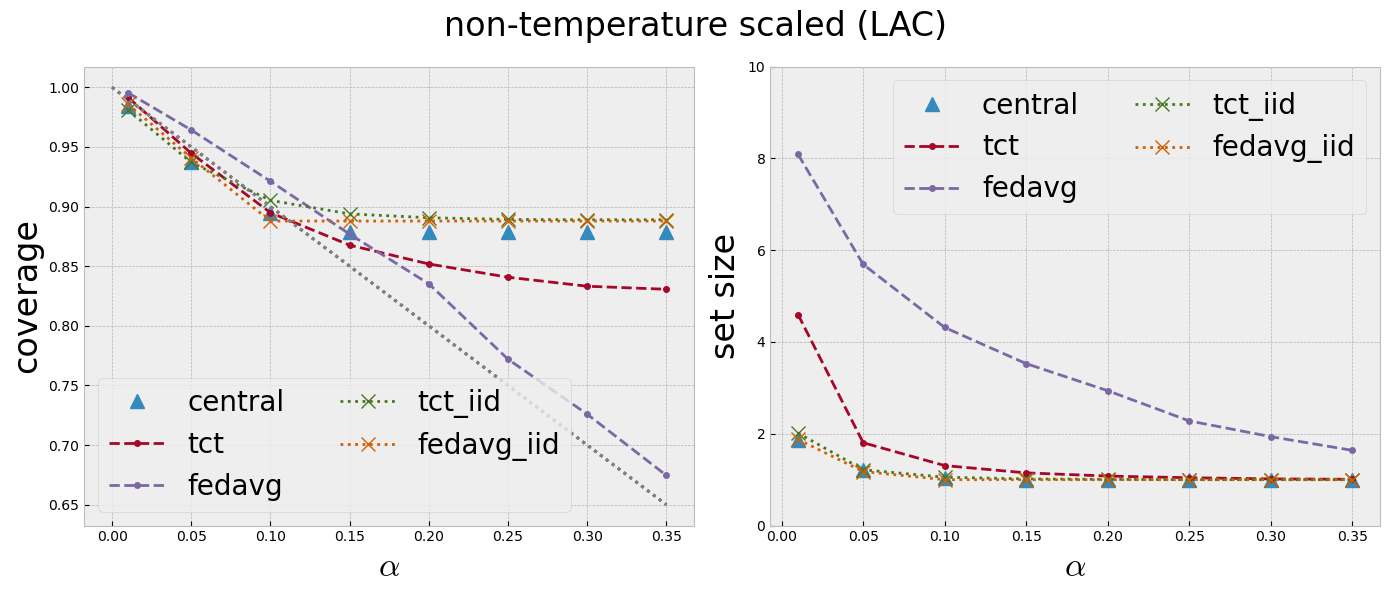

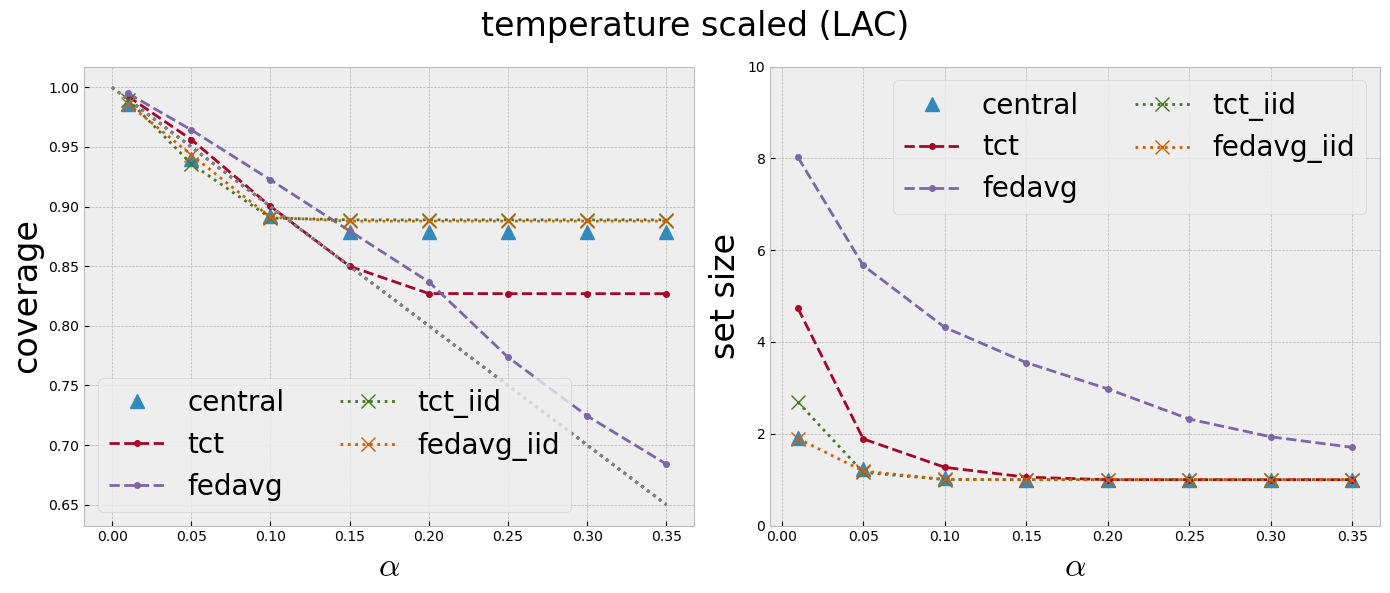

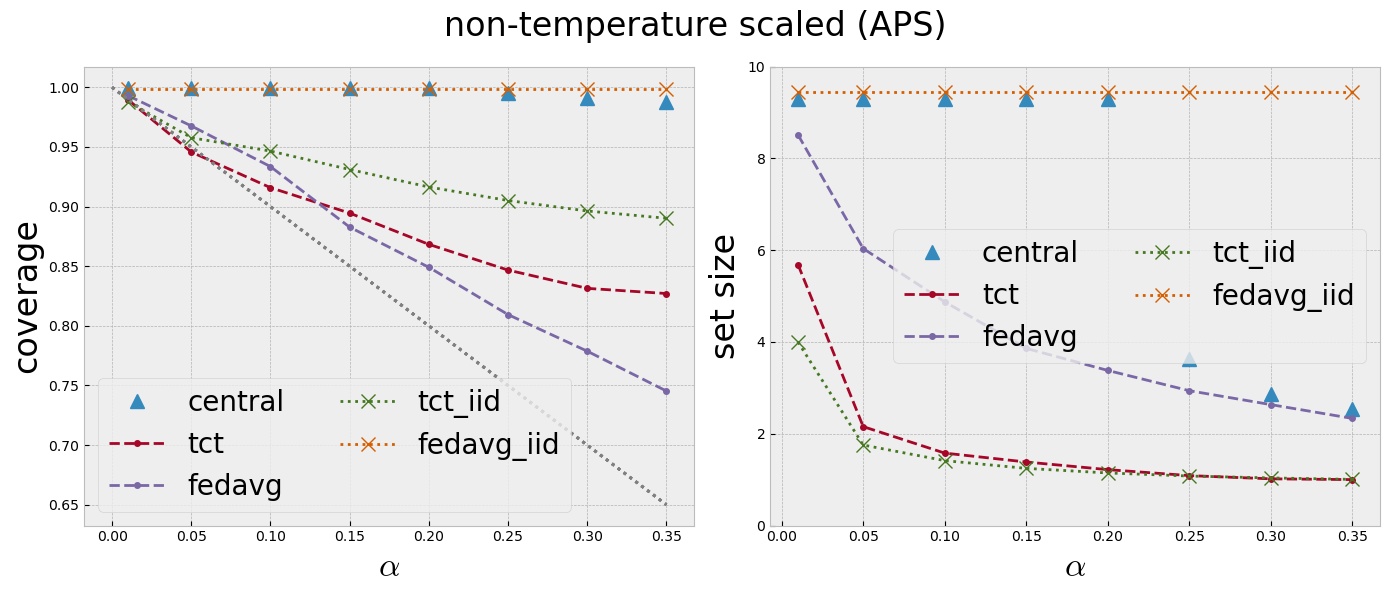

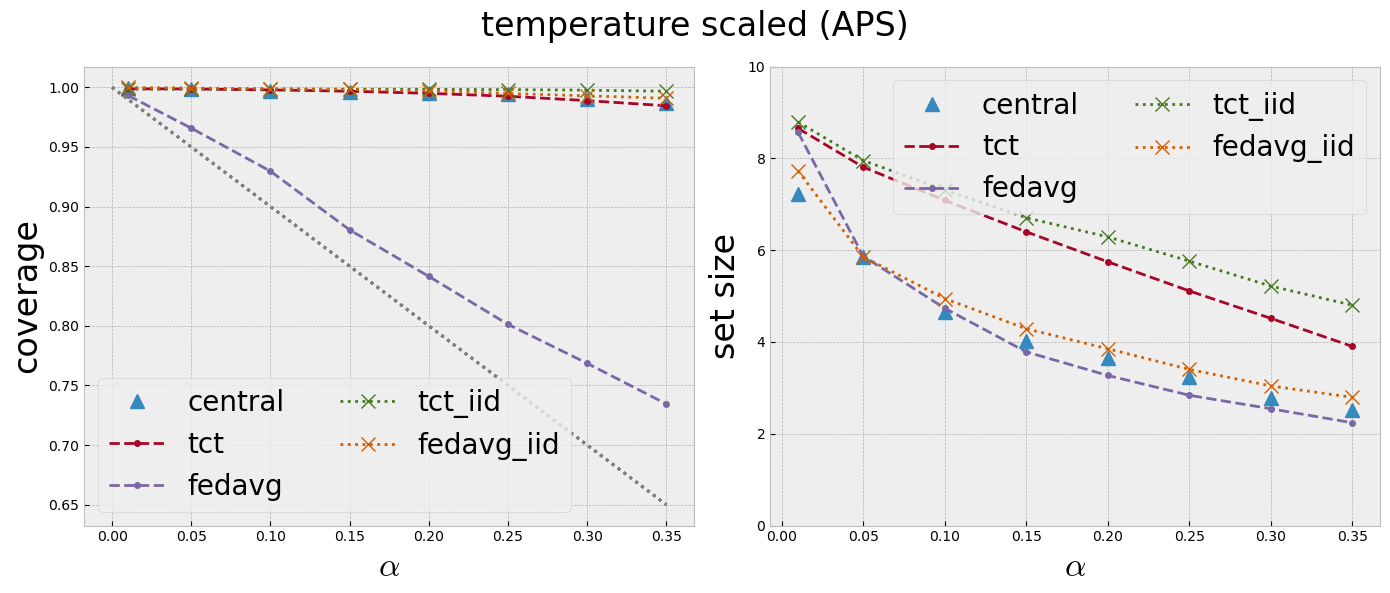

In [18]:
allow_empty_sets = False 

for method in 'lac', 'aps':
    non_temp_metrics = {
        k: get_conformal_metrics(*v, method=method, allow_empty_sets=allow_empty_sets) 
        for k, v in zip(experiments.keys(), map(f, experiments.values()))
    }
    temp_metrics = {
        k: get_conformal_metrics(*v, method=method, allow_empty_sets=allow_empty_sets, use_temp_scale=True) 
        for k, v in zip(experiments.keys(), map(f, experiments.values()))
    }
    plot_conformal(non_temp_metrics, title=f'non-temperature scaled ({method.upper()})', num_classes=num_classes)
    plot_conformal(temp_metrics, title=f'temperature scaled ({method.upper()})', num_classes=num_classes)

In [19]:
def tune_temp(logits, labels, binary_search=True, lower=0.2, upper=5.0, eps=0.0001):
    logits = np.array(logits)

    if binary_search:
        import torch
        import torch.nn.functional as F

        logits = torch.FloatTensor(logits)
        labels = torch.LongTensor(labels)
        t_guess = torch.FloatTensor([0.5*(lower + upper)]).requires_grad_()

        while upper - lower > eps:
            if torch.autograd.grad(F.cross_entropy(logits / t_guess, labels), t_guess)[0] > 0:
                upper = 0.5 * (lower + upper)
            else:
                lower = 0.5 * (lower + upper)
            t_guess = t_guess * 0 + 0.5 * (lower + upper)

        t = min([lower, 0.5 * (lower + upper), upper], key=lambda x: float(F.cross_entropy(logits / x, labels)))
    else:
        import cvxpy as cx

        set_size = np.array(logits).shape[0]

        t = cx.Variable()

        expr = sum((cx.Minimize(cx.log_sum_exp(logits[i, :] * t) - logits[i, labels[i]] * t)
                    for i in range(set_size)))
        p = cx.Problem(expr, [lower <= t, t <= upper])

        p.solve()   # p.solve(solver=cx.SCS)
        t = 1 / t.value

    return t


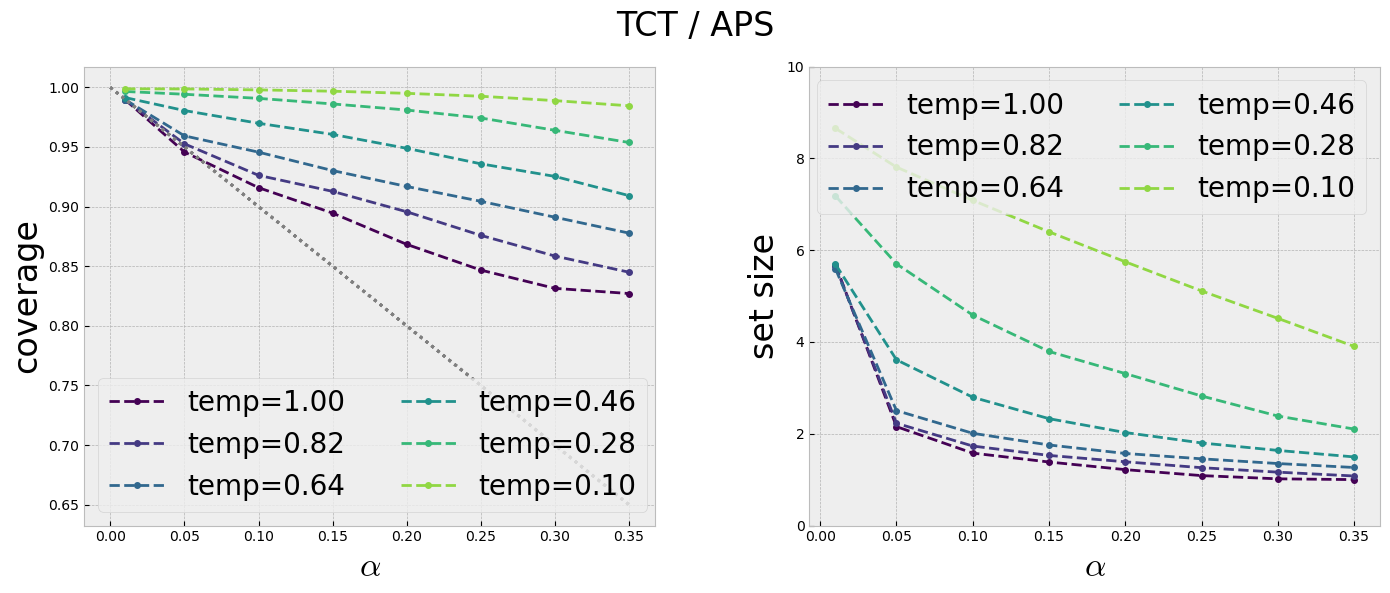

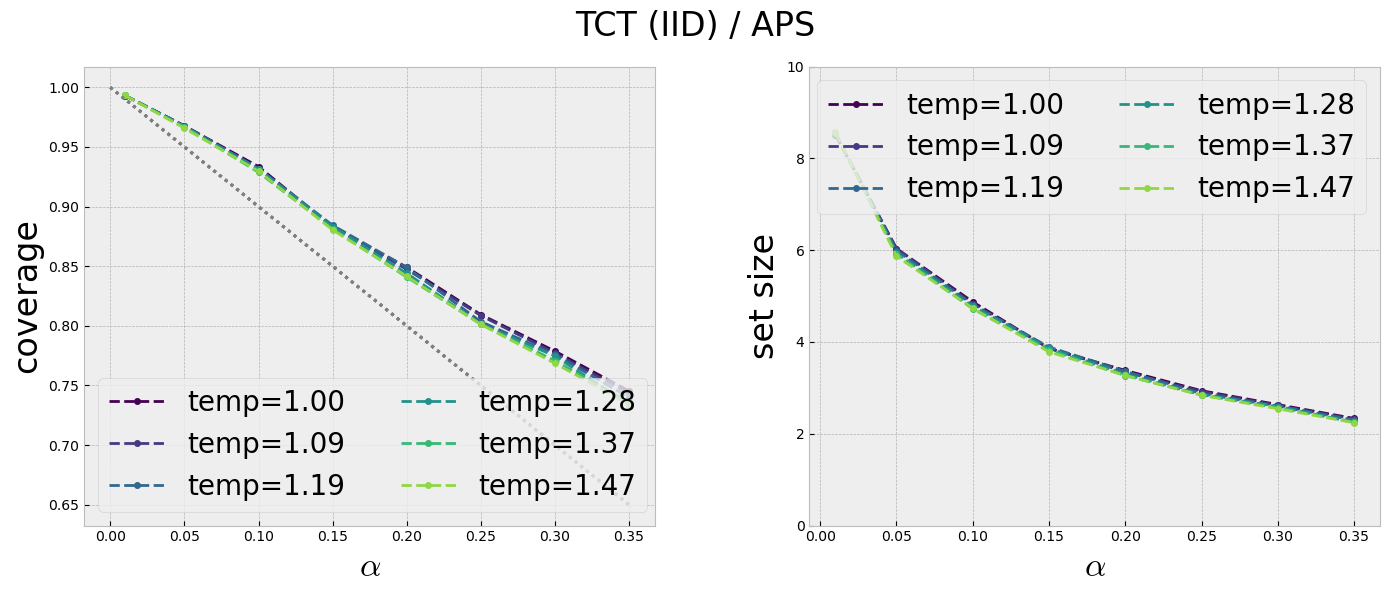

In [20]:
def plot_interpolated_temp(val_logits, val_targets, test_logits, test_targets, num_interp=5, fontsize=24, title=None, alphas=[0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35], method='aps', allow_empty_sets=False, num_classes=None):
    conformal_metrics = {}
    # T = tune_temp(val_logits, val_targets, False).item()
    T = temp_scale(val_logits, val_targets, False).item()
    for t in [x for x in np.linspace(1, T, num_interp + 1)]:
        conformal_metrics[f'temp={t:.2f}'] = get_conformal_metrics(
            val_logits, val_targets, test_logits, test_targets, 
            alphas=alphas,
            use_temp_scale=True,
            manual_temp=t,
            method=method,
            allow_empty_sets=allow_empty_sets,
        )
    plot_conformal(conformal_metrics, fontsize=fontsize, title=title, num_classes=num_classes, use_viridis=True)
    
method = 'aps'
allow_empty_sets = False
plot_interpolated_temp(*f(experiments['tct']), title=f'TCT / {method.upper()}', method=method, allow_empty_sets=allow_empty_sets, num_classes=num_classes)
plot_interpolated_temp(*f(experiments['fedavg']), title=f'TCT (IID) / {method.upper()}', method=method, allow_empty_sets=allow_empty_sets, num_classes=num_classes)

## conditional coverage

In [51]:
def get_client_conformal_metrics(
    clients_class_map: dict,
    val_logits, val_targets, test_logits, test_targets, 
    # alphas=[0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35],
    alphas=[0.01, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35],
    use_temp_scale=False,
    method='aps',
    allow_empty_sets=False,
):
    
    # partition clients by class label
    clients_val_index = {
        client: torch.any(torch.stack([val_targets == label for label in labels]), 0)
        for client, labels in clients_class_map.items()
    }

    clients_test_index = {
        client: torch.any(torch.stack([test_targets == label for label in labels]), 0)
        for client, labels in clients_class_map.items()
    }

    # temperature scaling
    clients_val_temp = {
        client: temp_scale(val_logits[index], val_targets[index], False) 
        for client, index in clients_val_index.items()
    }
    clients_val_scores = {
        client: torch.softmax(val_logits[index] / (clients_val_temp[client] if use_temp_scale else 1), 1)
        for client, index in clients_val_index.items()
    }
    clients_test_scores = {
        client: torch.softmax(test_logits[index] / (clients_val_temp[client] if use_temp_scale else 1), 1)
        for client, index in clients_test_index.items()
    }
    
    for k, v in clients_val_scores.items():
        assert len(v)
    for k, v in clients_test_scores.items():
        assert len(v)
    
    # choose score function
    if method == 'lac':
        score_func = calibrate_lac
        infer_func = inference_lac
    elif method == 'aps':
        score_func = calibrate_aps
        infer_func = inference_aps
    elif method == 'raps':
        score_func = calibrate_raps
        infer_func = inference_raps
    else:
        raise ValueError(f'{method} score function not implemented')
        
    # calibrate by estimating quantile in distributed manner
    clients_local_q, clients_decentral_q = defaultdict(dict), defaultdict(dict)
    clients_local_coverage, clients_local_size = defaultdict(dict), defaultdict(dict)
    clients_decentral_coverage, clients_decentral_size = defaultdict(dict), defaultdict(dict)
    clients_global_coverage, clients_global_size = defaultdict(dict), defaultdict(dict)
    
    # compute global quantile (pool all calibration samples together)
    global_temp = temp_scale(val_logits, val_targets, False) 
    global_val_scores = torch.softmax(val_logits / (global_temp if use_temp_scale else 1), 1)
    global_test_scores = {
        client: torch.softmax(test_logits[index] / (global_temp if use_temp_scale else 1), 1)
        for client, index in clients_test_index.items()
    }
    global_q = {alpha: score_func(global_val_scores, val_targets, alpha=alpha) for alpha in alphas}
    
    for client, index in clients_test_index.items():
        scores = clients_test_scores[client]
        targets = test_targets[index] 
        n = targets.shape[0]
        for alpha in alphas:
            global_psets = infer_func(scores, global_q[alpha], allow_empty_sets=allow_empty_sets)
            clients_global_coverage[client][alpha] = global_psets[torch.arange(n), targets].float().mean().item()
            clients_global_size[client][alpha] = global_psets.sum(1).float().mean().item()
    
    decentral_sketch = DDSketch()
    total_cal_samples = 0
    for client, index in clients_val_index.items():
        scores = clients_val_scores[client]
        targets = val_targets[index]
        total_cal_samples += targets.shape[0]
        
        assert len(scores), len(targets)
        
        # store local quantiles at different coverage thresholds to evaluate local coverage
        for alpha in alphas:
            local_q = score_func(scores, targets, alpha=alpha)
            # local_alpha_q[alpha] = local_q
            clients_local_q[client][alpha] = local_q
            
        dummy_alpha = 0.1
        _, score_dist = score_func(scores, targets, alpha=dummy_alpha, return_dist=True)
        
        # add client scores to quantile sketcher
        client_sketch = DDSketch()
        for score in score_dist.tolist():
            client_sketch.add(score)
        
        # merge client sketcher with decentral sketcher
        decentral_sketch.merge(client_sketch)
        
    assert total_cal_samples
        
    for client, index in clients_test_index.items():
        scores = clients_test_scores[client]
        targets = test_targets[index]
        n = targets.shape[0]

        # compute prediction sets with local and distributed quantiles
        for alpha, local_q in clients_local_q[client].items():
            decentral_q = decentral_sketch.get_quantile_value(np.ceil((total_cal_samples+1)*(1-alpha))/total_cal_samples)
            if method == 'lac':
                decentral_q = 1 - decentral_q
            clients_decentral_q[client][alpha] = decentral_q

            local_psets = infer_func(scores, local_q, allow_empty_sets=allow_empty_sets)
            decentral_psets = infer_func(scores, decentral_q, allow_empty_sets=allow_empty_sets)

            clients_local_coverage[client][alpha] = local_psets[torch.arange(n), targets].float().mean().item()
            clients_local_size[client][alpha] = local_psets.sum(1).float().mean().item()
            
            clients_decentral_coverage[client][alpha] = decentral_psets[torch.arange(n), targets].float().mean().item()
            clients_decentral_size[client][alpha] = decentral_psets.sum(1).float().mean().item()

    # combine into format for plotter
    local_metrics = defaultdict(dict)
    decentral_metrics = defaultdict(dict)
    global_metrics = defaultdict(dict)
    for client in clients_class_map.keys():
        local_metrics[client]['alphas'] = alphas
        local_metrics[client]['q'] = clients_local_q[client]
        local_metrics[client]['coverage'] = clients_local_coverage[client]
        local_metrics[client]['size'] = clients_local_size[client]
        
        decentral_metrics[client]['alphas'] = alphas
        decentral_metrics[client]['q'] = clients_decentral_q[client]
        decentral_metrics[client]['coverage'] = clients_decentral_coverage[client]
        decentral_metrics[client]['size'] = clients_decentral_size[client]
        
        global_metrics[client]['alphas'] = alphas
        global_metrics[client]['q'] = global_q
        global_metrics[client]['coverage'] = clients_global_coverage[client]
        global_metrics[client]['size'] = clients_global_size[client]
        
    return local_metrics, decentral_metrics, global_metrics

{'client_1': [0, 1], 'client_2': [2, 3], 'client_3': [4, 5], 'client_4': [6, 7], 'client_5': [8, 9]}


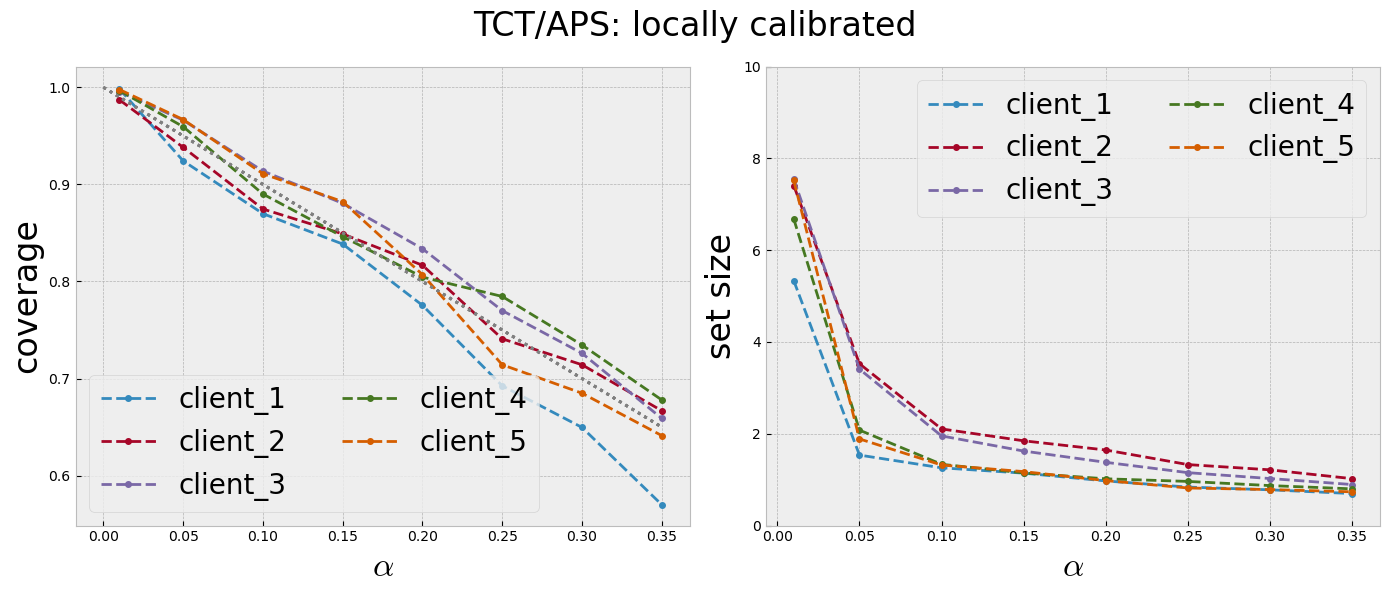

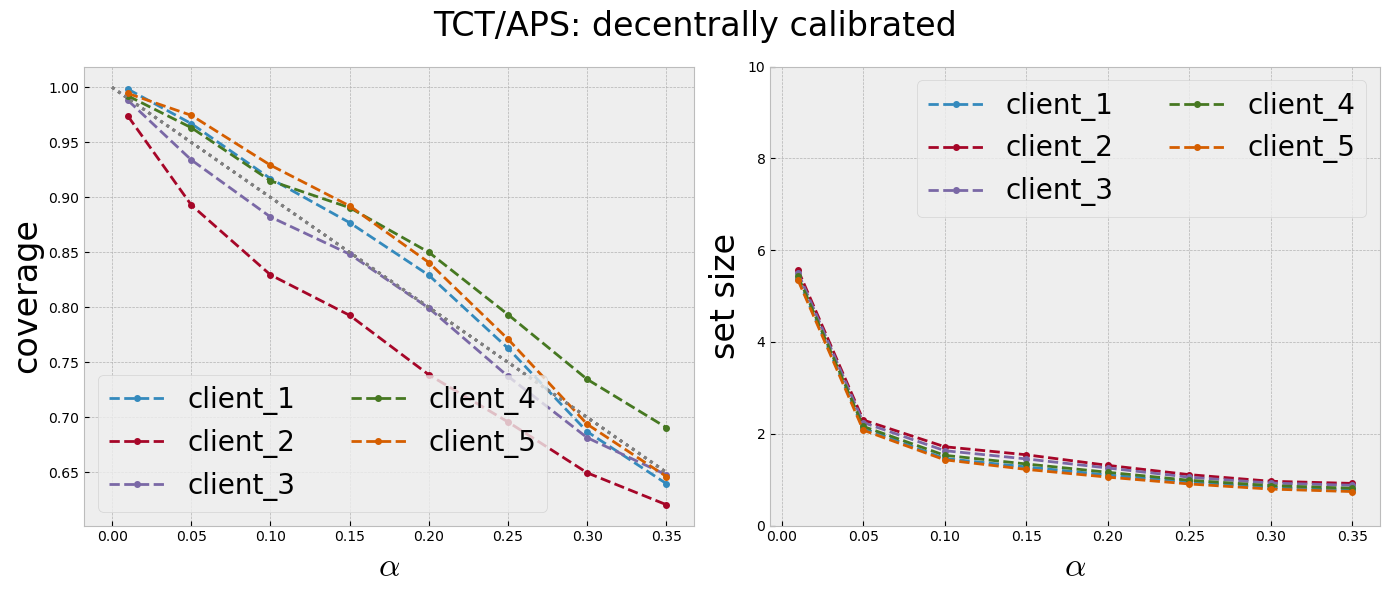

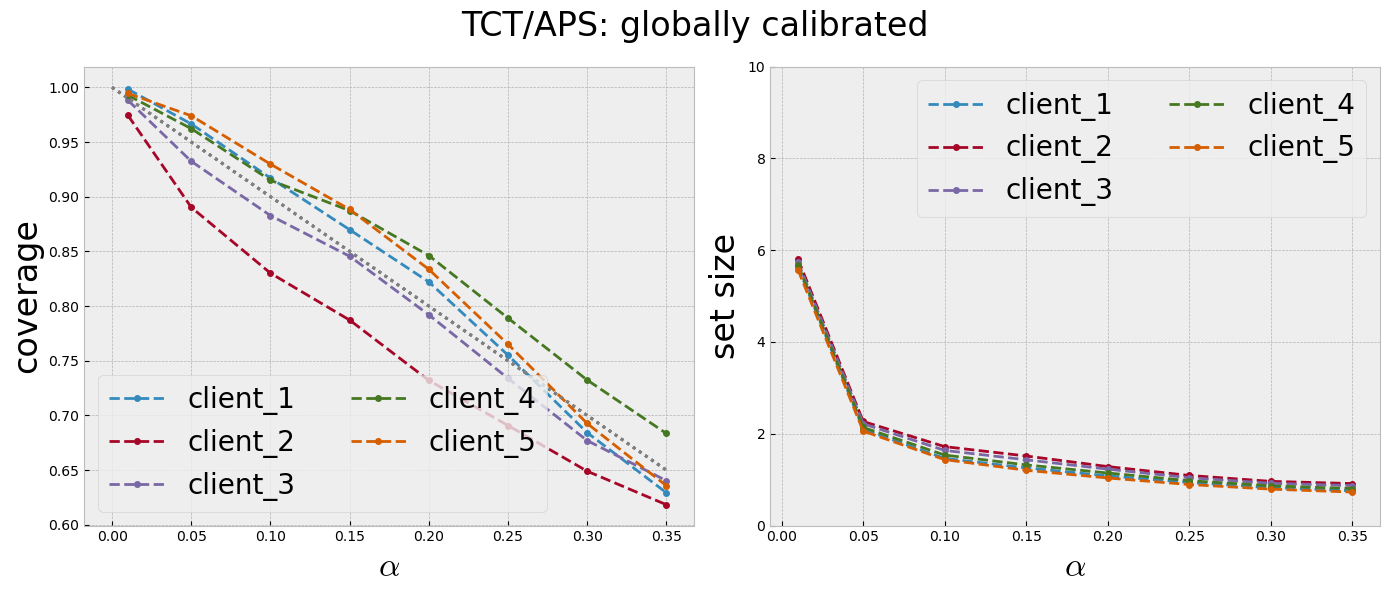

In [57]:
print(clients_class_map)
exp = 'tct'
method = 'aps'
allow_empty_sets = True

local_metrics, central_metrics, global_metrics= get_client_conformal_metrics(clients_class_map, *f(experiments[exp]), method=method, allow_empty_sets=allow_empty_sets)
plot_conformal(local_metrics, title=f'{exp.upper()}/{method.upper()}: locally calibrated', num_classes=num_classes)
plot_conformal(central_metrics, title=f'{exp.upper()}/{method.upper()}: decentrally calibrated', num_classes=num_classes)
plot_conformal(global_metrics, title=f'{exp.upper()}/{method.upper()}: globally calibrated', num_classes=num_classes)

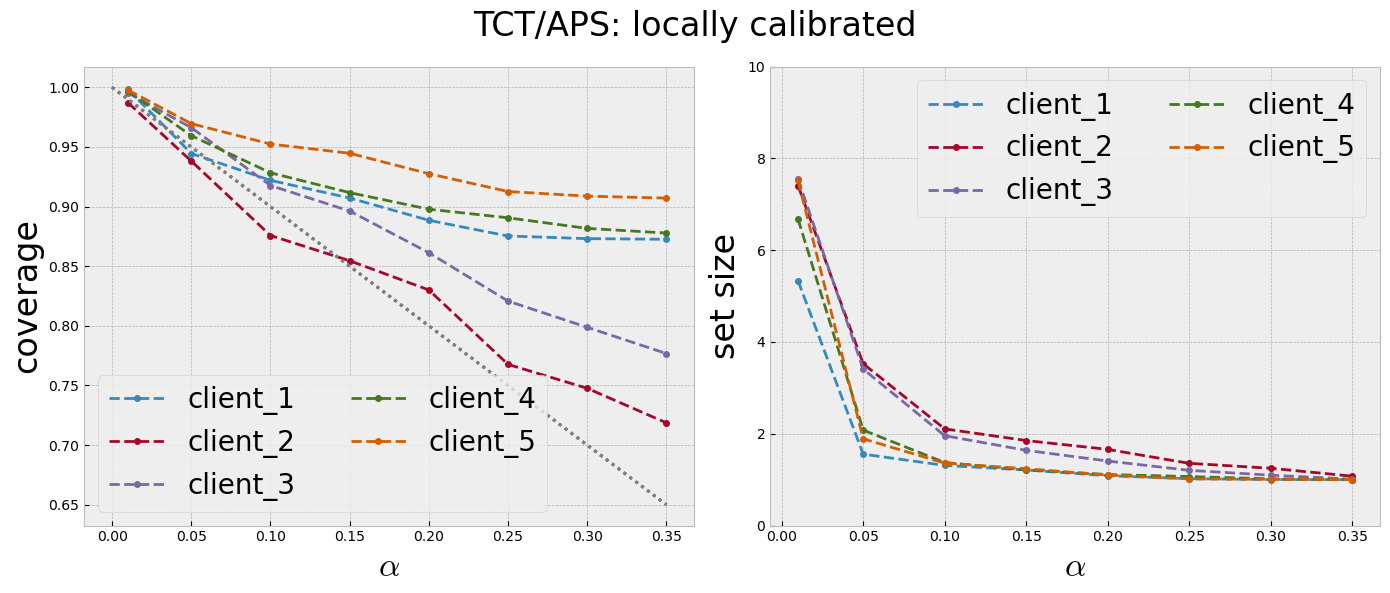

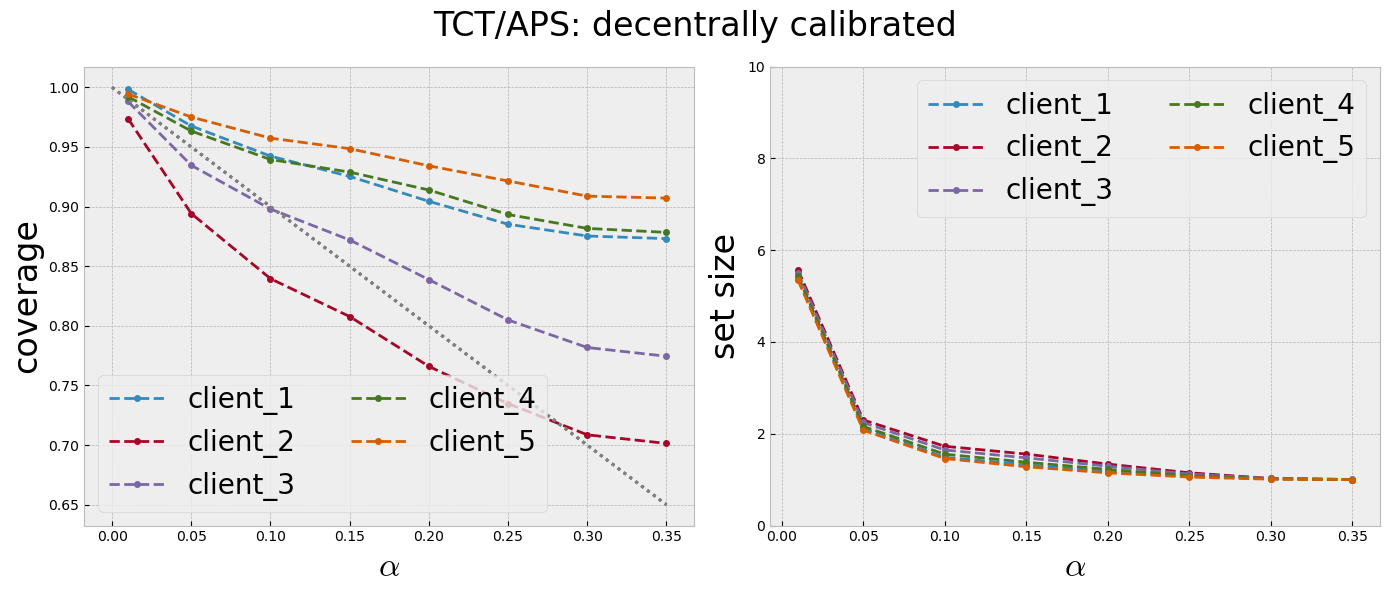

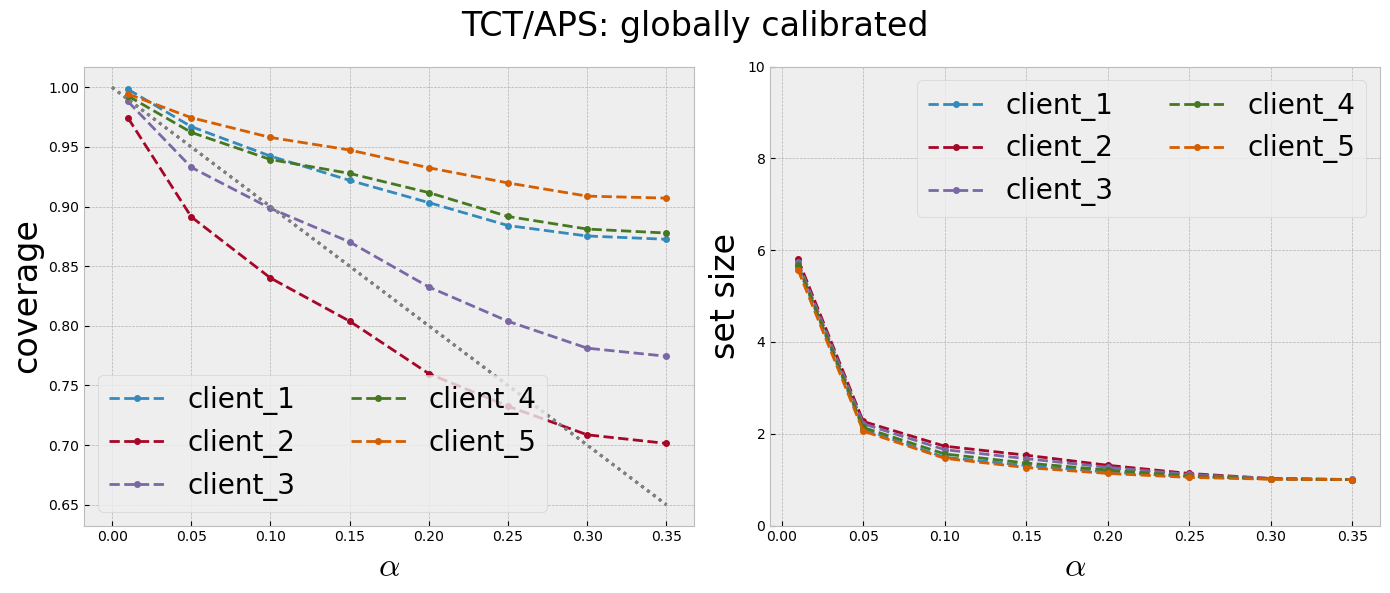

In [58]:
exp = 'tct'
method = 'aps'
allow_empty_sets = False

local_metrics, central_metrics, global_metrics= get_client_conformal_metrics(clients_class_map, *f(experiments[exp]), method=method, allow_empty_sets=allow_empty_sets)
plot_conformal(local_metrics, title=f'{exp.upper()}/{method.upper()}: locally calibrated', num_classes=num_classes)
plot_conformal(central_metrics, title=f'{exp.upper()}/{method.upper()}: decentrally calibrated', num_classes=num_classes)
plot_conformal(global_metrics, title=f'{exp.upper()}/{method.upper()}: globally calibrated', num_classes=num_classes)